In [1]:
# Making PF differentiable 


In [6]:
import torch
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Compute density using torch
def compute_density_torch(particles, x_bins, y_bins, theta_bins, device):
    # Get bin indices for each dimension
    x_inds = torch.bucketize(particles[:, 0], x_bins) - 1
    y_inds = torch.bucketize(particles[:, 1], y_bins) - 1
    t_inds = torch.bucketize(particles[:, 2], theta_bins) - 1
    
    # Create empty density tensor
    density = torch.zeros(len(x_bins)-1, len(y_bins)-1, len(theta_bins)-1, device=device)
    
    # Compute linear indices
    nx, ny = len(x_bins)-1, len(y_bins)-1
    linear_inds = x_inds + nx * y_inds + (nx * ny) * t_inds
    
    # Count particles in bins
    density_flat = density.flatten()
    density_flat.scatter_add_(0, linear_inds, torch.ones_like(linear_inds, dtype=torch.float32))
    
    # Normalize
    density = density_flat.reshape(len(x_bins)-1, len(y_bins)-1, len(theta_bins)-1)
    density = density / len(particles)
    
    return density

# Replace original code with:
density = compute_density_torch(particles, x_bins, y_bins, theta_bins, self.device)

In [70]:
import torch

def histogramdd_pytorch(particles, x_bins, y_bins, theta_bins, device):
    # Ensure the bins are on the same device
    x_bins = x_bins.to(device)
    y_bins = y_bins.to(device)
    theta_bins = theta_bins.to(device)

    # Compute the bin edges
    # For each dimension, extend the edges by half the bin width on both sides
    x_edges = torch.cat([x_bins[0:1] - (x_bins[1] - x_bins[0]) / 2, x_bins + (x_bins[1] - x_bins[0]) / 2])
    y_edges = torch.cat([y_bins[0:1] - (y_bins[1] - y_bins[0]) / 2, y_bins + (y_bins[1] - y_bins[0]) / 2])
    theta_edges = torch.cat([theta_bins[0:1] - (theta_bins[1] - theta_bins[0]) / 2, theta_bins + (theta_bins[1] - theta_bins[0]) / 2])

    # Compute histograms for each dimension (x, y, theta)
    hist_x = torch.histc(particles[:, 0], bins=x_bins.size(0)-1, min=x_edges[0], max=x_edges[-1])
    hist_y = torch.histc(particles[:, 1], bins=y_bins.size(0) -1, min=y_edges[0], max=y_edges[-1])
    hist_theta = torch.histc(particles[:, 2], bins=theta_bins.size(0) -1, min=theta_edges[0], max=theta_edges[-1])
    
    # Normalize histograms by dividing by the total count to get densities
    hist_x = hist_x / hist_x.sum()
    hist_y = hist_y / hist_y.sum()
    hist_theta = hist_theta / hist_theta.sum()

    # Reshape histograms to 3D grid
    hist_x = hist_x.view(-1, 1, 1)
    hist_y = hist_y.view(1, -1, 1)
    hist_theta = hist_theta.view(1, 1, -1)

    # Multiply histograms to compute the joint density
    density = hist_x * hist_y * hist_theta

    return density





In [40]:
x_bins[-1] + (x_bins[1] - x_bins[0]) / 2

tensor(0.5200, device='cuda:0')

In [72]:
# Replace original code with:
prior_cov = torch.tensor([0.1, 0.1, 0.1], device=device, dtype=torch.float64)  # (3,)
prior_cov_batch = torch.tile(prior_cov.unsqueeze(0), [batch_size, 1])  # (B, 3)
batch_size = 10
prior_cov_dig_batch = torch.tile(torch.diag(prior_cov).unsqueeze(0), [batch_size, 1, 1])  # (B, 3, 3)

grid_size = [25,25,32]
grid_bounds = [-0.5, 0.5]
n_particles = math.prod(grid_size)
L = torch.linalg.cholesky(prior_cov_dig_batch)  # (B, 3, 3)
noise = torch.randn((batch_size, 3, n_particles), device=device, dtype=torch.float64)  # (B, 3, N)

# L @ noise -> (B, 3, N), then transpose and add prior
particles_noise = torch.bmm(L, noise)  # (B, 3, N)
particles = particles_noise.permute(0, 2, 1) + prior_cov_batch.unsqueeze(1)  # (B, N, 3)

x_bins = torch.linspace(grid_bounds[0], grid_bounds[1], grid_size[0] + 1, device=device)
y_bins = torch.linspace(grid_bounds[0], grid_bounds[1], grid_size[1] + 1, device=device)
theta_bins = torch.linspace(-torch.pi, torch.pi, grid_size[2] + 1, device=device)
       
        
# density = compute_density_torch(particles[0], x_bins, y_bins, theta_bins, device)
density = histogramdd_pytorch(particles[0], x_bins, y_bins, theta_bins, device)

In [53]:
import numpy as np
particles_cpu = particles[0].cpu().numpy()
density_check, temp = np.histogramdd(particles_cpu,
                                        bins=(x_bins.cpu().numpy(), y_bins.cpu().numpy(), theta_bins.cpu().numpy()),
                                        density=True)

In [58]:
density_check.max()

np.float64(4.435343691580275)

/tmp/ipykernel_3656276/224494263.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  density_marginalized = np.trapz(density_check, x=theta_bins.cpu().numpy()[:-1], axis=-1)


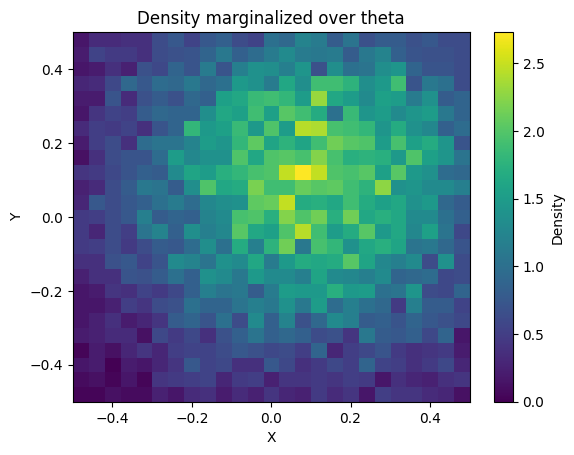

In [46]:
density.shape
import matplotlib.pyplot as plt

# Marginalize over theta (sum along the last axis)
density_marginalized = np.trapz(density_check, x=theta_bins.cpu().numpy()[:-1], axis=-1)

# Plot the marginalized density
plt.imshow(density_marginalized, extent=[grid_bounds[0], grid_bounds[1], grid_bounds[0], grid_bounds[1]], origin='lower', aspect='auto')
plt.colorbar(label='Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Density marginalized over theta')
plt.show()

tensor(5.9414e+09, device='cuda:0', dtype=torch.float64)

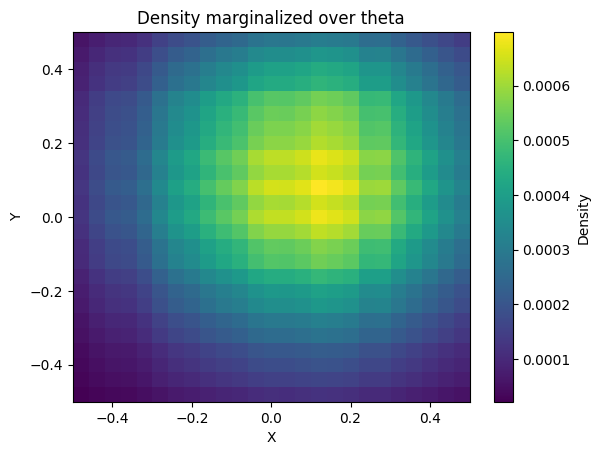

In [73]:
density.shape
import matplotlib.pyplot as plt

# Marginalize over theta (sum along the last axis)
density_marginalized = torch.trapz(density, x=theta_bins[:-1], axis=-1)

# Plot the marginalized density
plt.imshow(density_marginalized.cpu().numpy(), extent=[grid_bounds[0], grid_bounds[1], grid_bounds[0], grid_bounds[1]], origin='lower', aspect='auto')
plt.colorbar(label='Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Density marginalized over theta')
plt.show()

In [51]:
density.shape

torch.Size([25, 25, 32])